#**Predictive Business Intelligence for TikTok Shops: Machine Learning-Based Analysis of Traffic, Engagement, and Revenue Performance**

This project investigates how machine learning techniques can be applied to predict and classify business performance in a TikTok Shop environment using multiple datasets derived from actual seller analytics. The study integrates key performance data including traffic statistics, income reports, business overview metrics, and core shop statistics to uncover patterns and relationships among customer engagement, transaction behavior, and sales outcomes.

##**1. Product Card Traffic Stats**

###Combining the Datasets

In [ ]:
import pandas as pd

In [ ]:
files = [
    "/content/Product Card Traffic Stats_20251005065347.xlsx - Sheet1.csv",
    "/content/Product Card Traffic Stats_20251005065254.xlsx - Sheet1.csv",
    "/content/Product Card Traffic Stats_20251005065356.xlsx - Sheet1.csv",
    "/content/Product Card Traffic Stats_20251005065054.xlsx - Sheet1.csv"
]

In [ ]:
cleaned_dfs = []

Function to clean each file

In [ ]:
def load_and_clean(file):
    print(f"\nLoading: {file}")

    # First read normally
    df = pd.read_csv(file, header=None) # Changed to pd.read_csv

    # ---- Detect header row automatically ----
    header_row = None
    for i in range(5):  # check the first 5 rows
        row = df.iloc[i].astype(str).str.lower()
        if "time" in row.values:
            header_row = i
            break

    if header_row is None:
        raise ValueError(f"Could not identify header row for {file}")

    print(f"Header row detected at row index: {header_row}")

    # Read again with correct header
    df = pd.read_csv(file, header=header_row) # Changed to pd.read_csv

    # ---- Clean column names ----
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.replace("\ufeff", "", regex=False)
        .str.replace("\n", " ", regex=False)
    )

    # ---- Identify the actual Time column ----
    time_candidates = [col for col in df.columns if "time" in col.lower()]

    if len(time_candidates) == 0:
        raise ValueError(f"No Time column found in file {file}")

    time_col = time_candidates[0]
    print(f"Detected Time column: {time_col}")

    # ---- Convert Time to datetime ----
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

    # ---- Add source column ----
    df["Source_File"] = file.split("/")[-1]

    return df

Process all 4 files

In [ ]:
for file in files:
    cleaned = load_and_clean(file)
    cleaned_dfs.append(cleaned)


Loading: /content/Product Card Traffic Stats_20251005065347.xlsx - Sheet1.csv
Header row detected at row index: 2
Detected Time column: Time

Loading: /content/Product Card Traffic Stats_20251005065254.xlsx - Sheet1.csv
Header row detected at row index: 2
Detected Time column: Time

Loading: /content/Product Card Traffic Stats_20251005065356.xlsx - Sheet1.csv
Header row detected at row index: 2
Detected Time column: Time

Loading: /content/Product Card Traffic Stats_20251005065054.xlsx - Sheet1.csv
Header row detected at row index: 2
Detected Time column: Time


In [ ]:
combined = pd.concat(cleaned_dfs, ignore_index=True)

print("\nCombined shape before dropping duplicates:", combined.shape)


Combined shape before dropping duplicates: (96, 17)


Remove duplicates

In [ ]:
combined = combined.drop_duplicates()
print("Combined shape after dropping duplicates:", combined.shape)

Combined shape after dropping duplicates: (96, 17)


In [ ]:
combined.to_csv("/content/Product_Card_Traffic_CLEANED.csv", index=False)
print("\nSaved cleaned file as Product_Card_Traffic_CLEANED.csv")


Saved cleaned file as Product_Card_Traffic_CLEANED.csv


###**Machine Learning for Product Card Traffic**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [ ]:
PATH = "/content/Product_Card_Traffic_CLEANED.csv"
df = pd.read_csv(PATH)
print("Loaded:", PATH)
print(df.shape)
df.head()

Loaded: /content/Product_Card_Traffic_CLEANED.csv
(96, 17)


,Time,Views,Viewers,Unique Clicks,Clicks,Clicks Add to Cart,Add To Cart User,Customers,SKU orders,GMV (₱),Content attributed GMV (₱),View to Paid Rate,View to Click Rate,Click to Cart Rate,Click to Paid Rate,Cart to Paid Rate,Source_File
0,2025-09-01,37,26,1,1,1,1,0,0,0.0,0.0,0.00%,3.85%,100.00%,0.00%,0.00%,Product Card Traffic Stats_20251005065347.xlsx...
1,2025-09-02,28,19,1,1,0,0,0,0,0.0,0.0,0.00%,5.26%,0.00%,0.00%,0.00%,Product Card Traffic Stats_20251005065347.xlsx...
2,2025-09-03,31,20,2,4,0,0,0,0,0.0,0.0,0.00%,10.00%,0.00%,0.00%,0.00%,Product Card Traffic Stats_20251005065347.xlsx...
3,2025-09-04,23,18,1,1,0,0,0,0,0.0,0.0,0.00%,5.56%,0.00%,0.00%,0.00%,Product Card Traffic Stats_20251005065347.xlsx...
4,2025-09-05,29,23,6,6,0,0,0,0,0.0,0.0,0.00%,26.09%,0.00%,0.00%,0.00%,Product Card Traffic Stats_20251005065347.xlsx...


In [ ]:
df.columns = df.columns.astype(str).str.strip().str.replace("\ufeff","", regex=False)

Fix Percent Columns

In [ ]:
def percent_to_float(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    if "%" in x:
        return float(x.replace("%","")) / 100
    try:
        return float(x)
    except:
        return np.nan

for col in df.columns:
    if df[col].astype(str).str.contains("%").any():
        df[col] = df[col].apply(percent_to_float)

Fix GMV / Currency Columns

In [ ]:
def currency_to_float(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    x = x.replace("₱","").replace(",","").strip()
    try:
        return float(x)
    except:
        return np.nan

gmv_cols = [c for c in df.columns if "gmv" in c.lower()]
for col in gmv_cols:
    df[col] = df[col].apply(currency_to_float).fillna(0)

Assigning X and y variables

In [ ]:
feature_cols = [
    "Views", "Viewers", "Unique Clicks", "Clicks",
    "Clicks Add to Cart", "Add To Cart User",
    "Customers", "SKU orders",
    "View to Paid Rate", "View to Click Rate",
    "Click to Cart Rate", "Click to Paid Rate",
    "Cart to Paid Rate"
]

In [ ]:
feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

Using features: ['Views', 'Viewers', 'Unique Clicks', 'Clicks', 'Clicks Add to Cart', 'Add To Cart User', 'Customers', 'SKU orders', 'View to Paid Rate', 'View to Click Rate', 'Click to Cart Rate', 'Click to Paid Rate', 'Cart to Paid Rate']


In [ ]:
X = df[feature_cols].copy()

In [ ]:
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0)

Target variable

In [ ]:
gmv_target = gmv_cols[0]
median_gmv = df[gmv_target].median()

df["GMV_High"] = (df[gmv_target] > median_gmv).astype(int)
y = df["GMV_High"]

print("Median GMV:", median_gmv)
print(df["GMV_High"].value_counts())

Median GMV: 327.54499999999996
GMV_High
0    48
1    48
Name: count, dtype: int64


Scale features

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Defining models

In [ ]:
models = {
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

 K-Fold Cross Validation (10 folds)

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
}

results = []

for name, model in models.items():
    print(f"\nEvaluating model: {name}")

    model_scores = {}

    for score_name, score_method in scoring.items():
        cv_score = cross_val_score(model, X_scaled, y, cv=kf, scoring=score_method)
        model_scores[score_name] = (cv_score.mean(), cv_score.std())

    results.append([name] +
                   [model_scores["accuracy"][0], model_scores["precision"][0],
                    model_scores["recall"][0], model_scores["f1"][0]])


Evaluating model: kNN

Evaluating model: NaiveBayes

Evaluating model: DecisionTree

Evaluating model: LogisticRegression

Evaluating model: NeuralNetwork


Create Results Table

In [ ]:
results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy (Mean)", "Precision (Mean)", "Recall (Mean)", "F1 (Mean)"
])

print("\n===== FINAL K-FOLD RESULTS =====")
print(results_df)
results_df


===== FINAL K-FOLD RESULTS =====
                Model  Accuracy (Mean)  Precision (Mean)  Recall (Mean)  \
0                 kNN         0.958889            1.0000       0.934762   
1          NaiveBayes         0.960000            0.9475       0.980000   
2        DecisionTree         0.947778            0.9625       0.940000   
3  LogisticRegression         0.980000            0.9875       0.980000   
4       NeuralNetwork         0.990000            1.0000       0.980000   

   F1 (Mean)  
0   0.963131  
1   0.957222  
2   0.945714  
3   0.982222  
4   0.988889  


,Model,Accuracy (Mean),Precision (Mean),Recall (Mean),F1 (Mean)
0,kNN,0.958889,1.0000,0.934762,0.963131
1,NaiveBayes,0.960000,0.9475,0.980000,0.957222
2,DecisionTree,0.947778,0.9625,0.940000,0.945714
3,LogisticRegression,0.980000,0.9875,0.980000,0.982222
4,NeuralNetwork,0.990000,1.0000,0.980000,0.988889


**Explanation:**

`K-Fold Cross Validation` is a model evaluation technique used ***to measure how well a machine learning model will perform*** **on unseen data**. It is especially important in datasets that are small, like the Product Card Traffic Stats dataset, which contains only around 97 rows.

**Using K-Fold CV ensures** that every record in the dataset is used both for training and validation, **making the evaluation more reliable and less sensitive** to how the data is split.

K-Fold Cross Validation was used to ensure reliable model performance evaluation given the small size of the Product Card Traffic dataset. By training and testing the models across 10 different data splits, the results more accurately reflect the true predictive power of each algorithm.

###**Interpretation:**

All models performed **exceptionally well**, with mean accuracies ranging from 94.7% to 99.0%.
This indicates that the features in the Product Card Traffic Stats dataset (views, clicks, add-to-cart users, SKU orders, conversion rates) are **highly predictive of whether the GMV for a given day is high or low**.

**Best Performing Model**

`Neural Network` (MLPClassifier)
* Accuracy: 99.0% (highest)

* Precision: 1.0000 (perfect — zero false positives)

* Recall: 0.98 (almost perfect detection of high GMV days)

* F1-score: 0.9889 (best overall balance)

The neural network was able to capture nonlinear relationships between engagement metrics (e.g., clicks, add-to-cart, viewers) and GMV, resulting in the strongest predictive performance.

---
`Logistic Regression`
* Accuracy: 98%

* Precision: 98.75%

* mRecall: 98%

* F1-score: 98.22%

This indicates that the relationship between the traffic metrics and GMV is almost linearly separable, meaning simpler models can classify high vs. low GMV very effectively.

---

**Good Performance from Simpler Models**

`kNN`

* Precision = 1.00 → when it predicts high GMV, it is always correct

* Recall = 0.9348 → but it sometimes misses true high GMV days


`Naive Bayes`

* Highest recall (0.98) among simple models

* Slightly lower precision (0.9475), meaning it sometimes predicts high GMV too often (common for NB due to independence assumptions)

`Decision Tree`

* Performs well but is more prone to overfitting

* Accuracy = 94.7%, lowest among the 5 models (Still very strong performance overall)

Using 10-fold cross-validation, the Neural Network model achieved the highest performance (Accuracy = 99%, F1 = 0.9889), indicating that engagement and product traffic metrics from TikTok Shop are strongly predictive of daily GMV outcomes, with even simple models exceeding 95% accuracy.

##**2. Overview of the Business**

In [ ]:
files = [
    "/content/Overview_My Business Performance_20251005064530.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064646.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064700.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064715.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064726.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064739.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064749.xlsx - Sheet2.csv",
    "/content/Overview_My Business Performance_20251005064801.xlsx - Sheet2.csv"
]

In [ ]:
overview_dfs = []

In [ ]:
def load_overview(path):
    print(f"\nLoading: {path}")

    # Load raw file
    df = pd.read_csv(path, header=0)

    # Clean column names
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.replace("\ufeff", "", regex=False)
        .str.replace("\n", " ", regex=False)
    )

    # Add source file identifier
    df["Source_File"] = path.split("/")[-1]

    return df

# ============================================================
# 3. Load all 8 files into a list
# ============================================================

for f in files:
    try:
        df_f = load_overview(f)
        overview_dfs.append(df_f)
    except Exception as e:
        print(f"⚠️ Error loading {f}: {e}")


Loading: /content/Overview_My Business Performance_20251005064530.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064646.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064700.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064715.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064726.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064739.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064749.xlsx - Sheet2.csv

Loading: /content/Overview_My Business Performance_20251005064801.xlsx - Sheet2.csv


In [ ]:
combined = pd.concat(overview_dfs, ignore_index=True)
print("\nCombined shape BEFORE dropping duplicates:", combined.shape)


Combined shape BEFORE dropping duplicates: (246, 12)


In [ ]:
combined = combined.drop_duplicates()
print("Combined shape AFTER dropping duplicates:", combined.shape)

Combined shape AFTER dropping duplicates: (246, 12)


In [ ]:
date_cols = [c for c in combined.columns if "date" in c.lower()]

if len(date_cols) > 0:
    date_col = date_cols[0]
    print("Detected date column:", date_col)

    combined[date_col] = pd.to_datetime(combined[date_col], errors="coerce")
    combined = combined.sort_values(by=date_col).reset_index(drop=True)
else:
    print("⚠️ No 'Date' column detected — skipping sorting.")

Detected date column: Date


In [ ]:
output_path = "/content/Overview_MyBusiness_CLEANED.csv"
combined.to_csv(output_path, index=False)

In [ ]:
df_overview = pd.read_csv('/content/Overview_MyBusiness_CLEANED.csv')

In [ ]:
df_overview.head()

,Date,Gross merchandise value (₱),Refunds (₱),Gross revenue with platform product subsidy breakdown,Items sold,Customers,Page views,Shop page visits,SKU orders,Orders,Conversion rate,Source_File
0,2025-02-01,0.0,0.0,NaN,0,0,4,4,0,0,0.00%,Overview_My Business Performance_2025100506480...
1,2025-02-02,679.0,0.0,679.0,7,2,14,12,5,2,16.67%,Overview_My Business Performance_2025100506480...
2,2025-02-03,0.0,0.0,NaN,0,0,6,5,0,0,0.00%,Overview_My Business Performance_2025100506480...
3,2025-02-04,7992.0,0.0,7992.0,77,26,111,62,44,26,41.94%,Overview_My Business Performance_2025100506480...
4,2025-02-05,3300.0,0.0,3300.0,31,13,70,32,22,14,40.63%,Overview_My Business Performance_2025100506480...


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
plt.style.use("seaborn-v0_8-darkgrid")

In [ ]:
df_overview.columns = df_overview.columns.astype(str).str.strip().str.replace("\ufeff", "")

In [ ]:
df_overview["Date"] = pd.to_datetime(df_overview["Date"], errors="coerce")

In [ ]:
df_overview = df_overview.sort_values("Date").reset_index(drop=True)

FIX PERCENTAGE & CURRENCY COLUMNS

In [ ]:
def percent_to_float(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    if "%" in x:
        return float(x.replace("%",""))/100
    try:
        return float(x)
    except:
        return np.nan

df_overview["Conversion rate"] = df_overview["Conversion rate"].apply(percent_to_float).fillna(0)

currency_cols = ["Gross merchandise value (₱)", "Refunds (₱)",
                 "Gross revenue with platform product subsidy breakdown"]

def currency_clean(x):
    if pd.isna(x): return 0
    x = str(x).replace("₱","").replace(",","")
    try: return float(x)
    except: return 0

for col in currency_cols:
    df_overview[col] = df_overview[col].apply(currency_clean).fillna(0)

HANDLE MISSING VALUES

In [ ]:
df_overview = df_overview.fillna(0)

MOVING AVERAGES (TREND SMOOTHING)

In [ ]:
df_overview["GMV_MA7"] = df_overview["Gross merchandise value (₱)"].rolling(7).mean()
df_overview["Orders_MA7"] = df_overview["Orders"].rolling(7).mean()
df_overview["Views_MA7"] = df_overview["Page views"].rolling(7).mean()

###**Data Visualization**

####**DAILY GMV TREND**

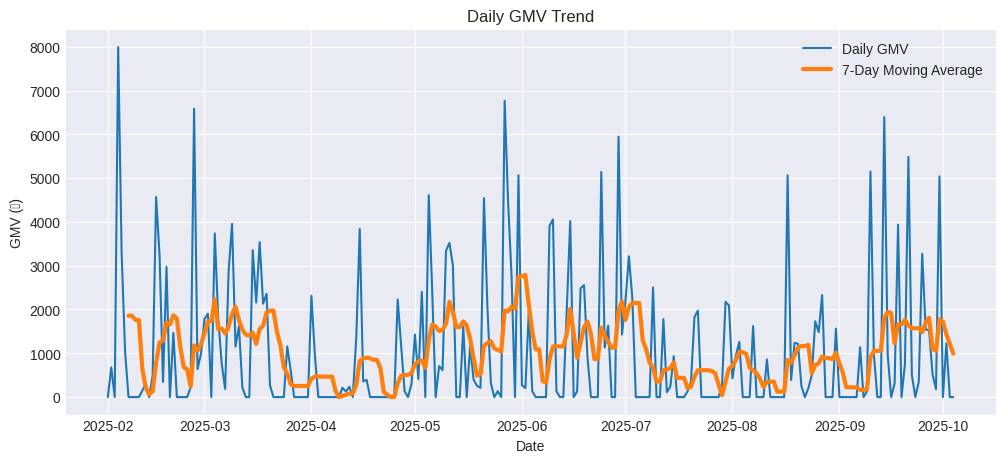

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_overview["Date"], df_overview["Gross merchandise value (₱)"], label="Daily GMV")
plt.plot(df_overview["Date"], df_overview["GMV_MA7"], label="7-Day Moving Average", linewidth=3)
plt.title("Daily GMV Trend")
plt.xlabel("Date")
plt.ylabel("GMV (₱)")
plt.legend()
plt.show()

GMV fluctuates heavily from day to day, showing a highly volatile sales pattern.
* There are sharp spikes reaching ₱5,000–₱8,000 on certain days, followed by drops close to ₱0.
* The 7-day moving average (orange line) smooths the data and reveals clearer cycles of short periods of higher GMV followed by dips or near-zero days.

The store experiences irregular sales patterns, indicating that orders and customer activity are **not consistent daily**.
* High GMV days might be driven by viral product posts as well as iscounts or promotions.
* Low GMV days likely indicate low engagement, no campaigns running, and slow traffic days

The shop does not generate stable daily revenue; instead, it relies on **occasional high-performing days that significantly contribute to total monthly GMV**.

####**ITEMS SOLD, ORDERS, CUSTOMERS**

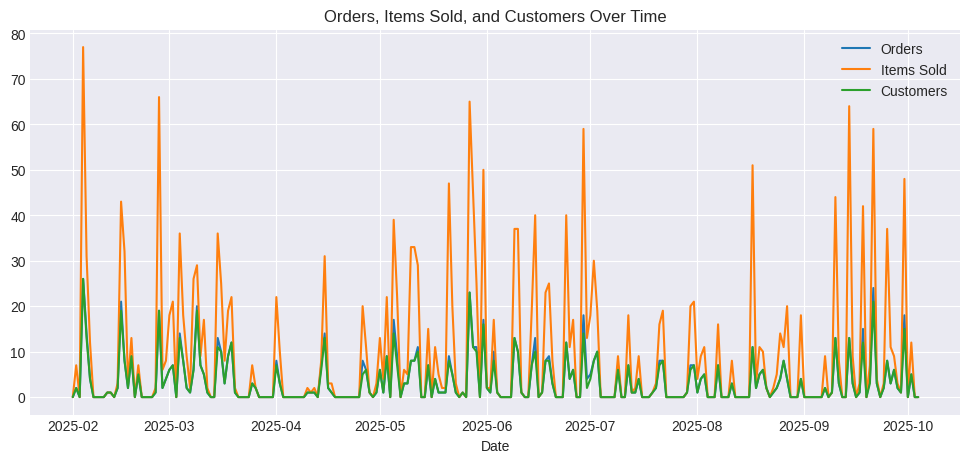

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_overview["Date"], df_overview["Orders"], label="Orders")
plt.plot(df_overview["Date"], df_overview["Items sold"], label="Items Sold")
plt.plot(df_overview["Date"], df_overview["Customers"], label="Customers")
plt.title("Orders, Items Sold, and Customers Over Time")
plt.xlabel("Date")
plt.legend()
plt.show()

**Observations**
* Items Sold experiences the highest spikes (peaks near 70–80 units).
* Orders remain lower, generally between 1–20 per day.
* Customers follow a pattern similar to Orders, exceeding 10 on few occasions.

**Items Sold being greater than the number of Orders indicates:**
* Customers often buy multiple units per order.
* Some viral days cause bulk purchases.

Most days have low customer counts. This means that the shop relies on a small number of buyers, but some buy multiple items. **Sales volume** is not driven by many customers, but rather **by a small group of customers purchasing multiple items**, especially during peak days.

####**CONVERSION RATE TREND**

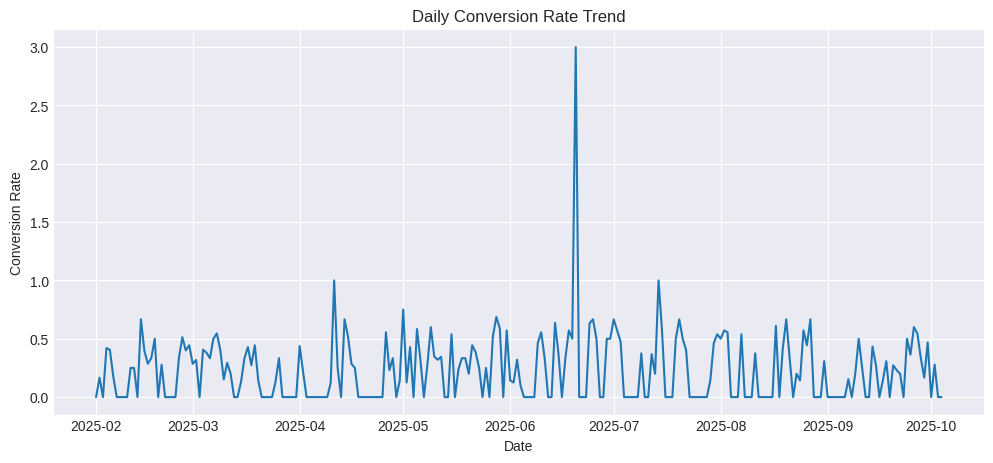

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_overview["Date"], df_overview["Conversion rate"], label="Conversion Rate")
plt.title("Daily Conversion Rate Trend")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.show()

Conversion rate fluctuates between 0% and ~1% on most days. There is one extreme spike around 3.0 (300%), which is mathematically possible when very low page views are recorded but small number of orders occur, inflating conversion %.
* The conversion rate is highly sensitive due to small traffic volumes.
* The conversion spike indicates low traffic or views but at least one order.
* Most days have low to moderate conversion, suggesting that many visitors do not convert into buyers.

Conversion rates appear unstable and are influenced by low traffic conditions. Improvements in product pages, ad targeting, and content quality could stabilize and increase conversion.

####**PAGE VIEWS AND SHOP VISITS TREND**

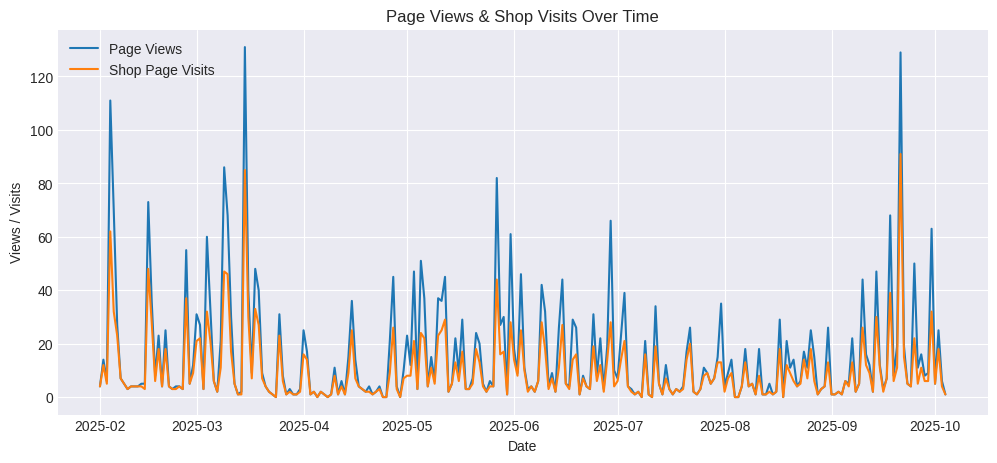

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_overview["Date"], df_overview["Page views"], label="Page Views")
plt.plot(df_overview["Date"], df_overview["Shop page visits"], label="Shop Page Visits")
plt.title("Page Views & Shop Visits Over Time")
plt.xlabel("Date")
plt.ylabel("Views / Visits")
plt.legend()
plt.show()

**Observations**
* Page Views consistently exceed Shop Page Visits, as expected.

* Spikes appear around the same dates as GMV and Orders spikes.

* There are multiple days with very low or even zero traffic.

**Interpretation**
* Traffic patterns closely follow sales behavior where High view/visit spikes correspond to high GMV days.
* Low-traffic days result in low sales or zero GMV.

Traffic is one of the strongest drivers of revenue for the store. Increasing daily reach—through content posting, ads, or influencer collaboration—will directly lift GMV

The overall trend in the plots indicates that the business relies on episodic peaks in visibility and engagement to generate revenue. Sustained performance would require strategies that increase daily traffic, stabilize conversion, and encourage more consistent purchasing behavior.

##**3. Income**

In [ ]:
files = [
    "/content/income_20251005070625.xlsx - Order details.csv",
    "/content/income_20251005070436.xlsx - Order details.csv",
    "/content/income_20251005070001.xlsx - Order details.csv"
]

income_dfs = []

In [ ]:
def load_income(path):
    print(f"\nLoading: {path}")

    # Load file
    df = pd.read_csv(path, header=0)

    # Clean column names
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.replace("\ufeff", "", regex=False)
        .str.replace("\n", " ", regex=False)
    )

    # Add file identifier
    df["Source_File"] = path.split("/")[-1]

    return df

In [ ]:
for f in files:
    try:
        df_temp = load_income(f)
        income_dfs.append(df_temp)
    except Exception as e:
        print(f"⚠️ Error loading {f}: {e}")


Loading: /content/income_20251005070625.xlsx - Order details.csv

Loading: /content/income_20251005070436.xlsx - Order details.csv

Loading: /content/income_20251005070001.xlsx - Order details.csv


In [ ]:
df_income = pd.concat(income_dfs, ignore_index=True)
print("\nCombined shape BEFORE dropping duplicates:", df_income.shape)


Combined shape BEFORE dropping duplicates: (488, 52)


In [ ]:
date_cols = ["Order created time", "Order settled time"]

for col in date_cols:
    if col in df_income.columns:
        df_income[col] = pd.to_datetime(df_income[col], errors="coerce")

In [ ]:
df_income = df_income.drop_duplicates()
print("Combined shape AFTER dropping duplicates:", df_income.shape)

Combined shape AFTER dropping duplicates: (488, 52)


In [ ]:
if "Order created time" in df_income.columns:
    df_income = df_income.sort_values("Order created time").reset_index(drop=True)
else:
    print("⚠️ Warning: 'Order created time' column not found. Skipping sorting.")

In [ ]:
output_path = "/content/Income_FULL_CLEANED.csv"
df_income.to_csv(output_path, index=False)

In [ ]:
df_income = pd.read_csv("/content/Income_FULL_CLEANED.csv")
df_income.head()

,Order/adjustment ID,Type,Order created time,Order settled time,Currency,Total settlement amount,Total revenue,Subtotal after seller discounts,Subtotal before discounts,Seller discounts,...,Seller co-funded voucher discount,Refund of seller co-funded voucher discount,Platform discounts,Refund of platform discounts,Platform co-funded voucher discounts,Refund of platform co-funded voucher discounts,Seller shipping fee discount,Estimated package weight (g),Actual package weight (g),Source_File
0,579371750383781222,Order,2025-06-24,2025-07-07,PHP,348.78,387,387,387,0,...,0,0,0.0,0.0,0,0,0,12,100.0,income_20251005070625.xlsx - Order details.csv
1,579393705311569233,Order,2025-06-26,2025-07-01,PHP,224.44,249,249,249,0,...,0,0,0.0,0.0,0,0,0,9,100.0,income_20251005070625.xlsx - Order details.csv
2,579399676018591400,Order,2025-06-26,2025-07-02,PHP,318.02,353,353,353,0,...,0,0,0.0,0.0,0,0,0,8,100.0,income_20251005070625.xlsx - Order details.csv
3,579398783377835849,Order,2025-06-26,2025-07-02,PHP,88.25,99,99,99,0,...,0,0,0.0,0.0,0,0,0,3,100.0,income_20251005070625.xlsx - Order details.csv
4,579398138647970946,Order,2025-06-26,2025-07-01,PHP,228.84,250,250,250,0,...,0,0,120.0,0.0,0,0,0,5,100.0,income_20251005070625.xlsx - Order details.csv


###**Analysis**

In [ ]:
df_income["Order created time"] = pd.to_datetime(df_income["Order created time"], errors='coerce')
df_income["Order settled time"] = pd.to_datetime(df_income["Order settled time"], errors='coerce')

df_income = df_income.sort_values("Order created time")

Net revenue after all fees


In [ ]:
df_income["Net Revenue"] = (
    df_income["Total settlement amount"]
)

Total fees (absolute value since they are negative)

In [ ]:
fee_cols = [
    "Total fees", "Transaction fee", "TikTok Shop commission fee",
    "Seller shipping fee", "Actual shipping fee",
    "Platform shipping fee discount", "Affiliate commission",
    "Affiliate partner commission",
    "Refund customer shipping fee",
    "Shipping fee subsidy"
]

In [ ]:
df_income["Total Fees ABS"] = df_income[fee_cols].sum(axis=1)

Refund indicator


In [ ]:
df_income["Has Refund"] = df_income["Customer refund"].apply(lambda x: 1 if x > 0 else 0)

**DAILY AGGREGATION**

In [ ]:
daily = df_income.groupby(df_income["Order created time"].dt.date).agg({
    "Total settlement amount": "sum",
    "Total revenue": "sum",
    "Net Revenue": "sum",
    "Total Fees ABS": "sum",
    "Has Refund": "sum",
}).reset_index()

daily.rename(columns={"Order created time": "Date"}, inplace=True)

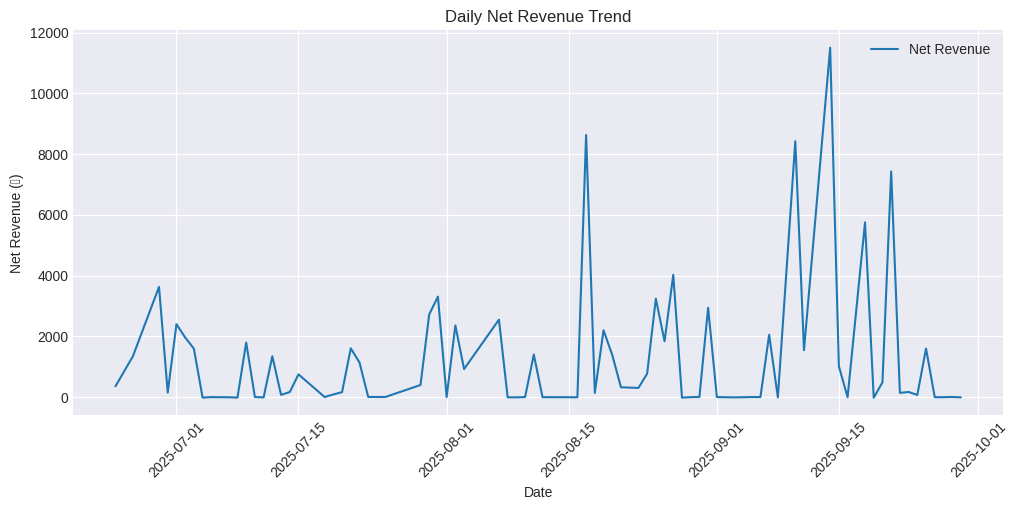

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily["Date"], daily["Net Revenue"], label="Net Revenue")
plt.title("Daily Net Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Net Revenue (₱)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Net revenue fluctuates dramatically from late June to late September. Many days show near-zerorevenue, indicating no orders.
Major revenue spikes occur on:

* August 17 (~₱8,600+)

* September 10 (~₱8,400+)

* September 14 (~₱11,500+)

* September 18 (~₱5,700+)

The shop does not generate consistent daily income and revenue relies heavily on a small number of high-performing days. Similar to initial interpretation, the long stretches of low revenue suggest irregular posting, inconsistent, and seasonal demand patterns.

The business is driven by episodic bursts of buyer activity. Focusing on replicating the conditions that cause revenue spikes—such as ads or creator content—may stabilize earnings.

**Revenue vs Total Fees**

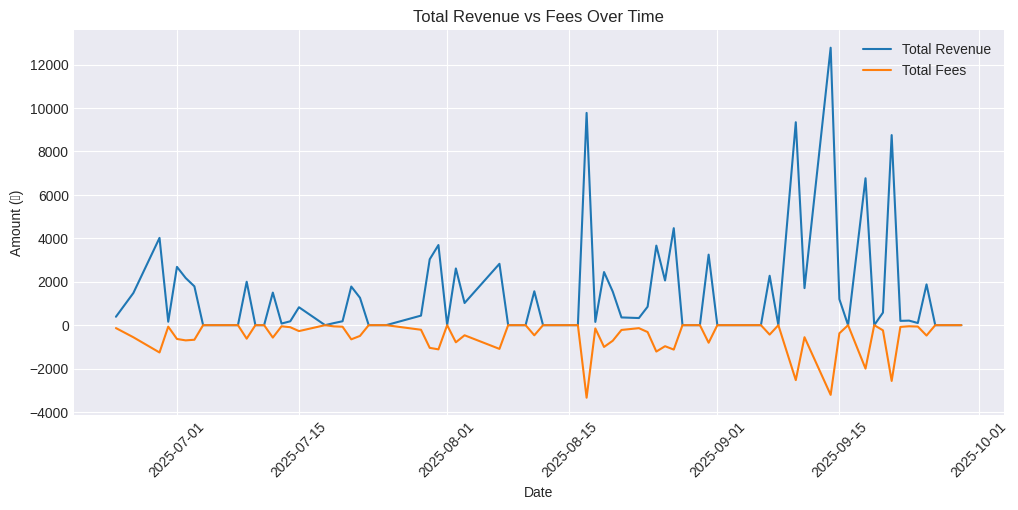

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily["Date"], daily["Total revenue"], label="Total Revenue")
plt.plot(daily["Date"], daily["Total Fees ABS"], label="Total Fees")
plt.title("Total Revenue vs Fees Over Time")
plt.xlabel("Date")
plt.ylabel("Amount (₱)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Observations**
* Total Revenue (blue) spikes align with the same high-GMV dates.

* Total Fees (orange) remain consistently negative, showing daily operational costs.

**On high-revenue days, fees also increase** — especially commission, transaction fees, and shipping fees.

Some days show extremely high negative fees (up to -₱3,300 to -₱4,000).

**Interpretations**
Fees grow proportionally with revenue. The biggest negative fee spikes occur on:

* High order volume days


* Refund-related adjustments

* Orders with heavy shipping fees

Large fee deductions significantly reduce daily net revenue. Shipping fees and platform commissions account for substantial operational costs.

**Refund Activity Over Time**

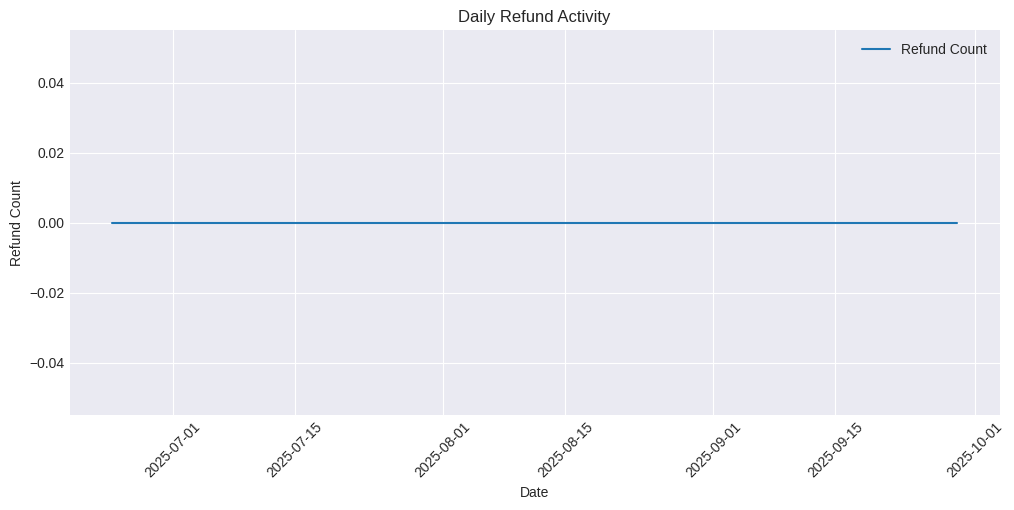

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(daily["Date"], daily["Has Refund"], label="Refund Count")
plt.title("Daily Refund Activity")
plt.xlabel("Date")
plt.ylabel("Refund Count")
plt.xticks(rotation=45)
plt.legend()
plt.show()

The refund count stays at exactly **zero for the entire period**. No refunds were processed between June and September.

The store maintained a **refund-free period**, suggesting low return rates and generally satisfied customers.

**FEE BREAKDOWN PIE CHART**

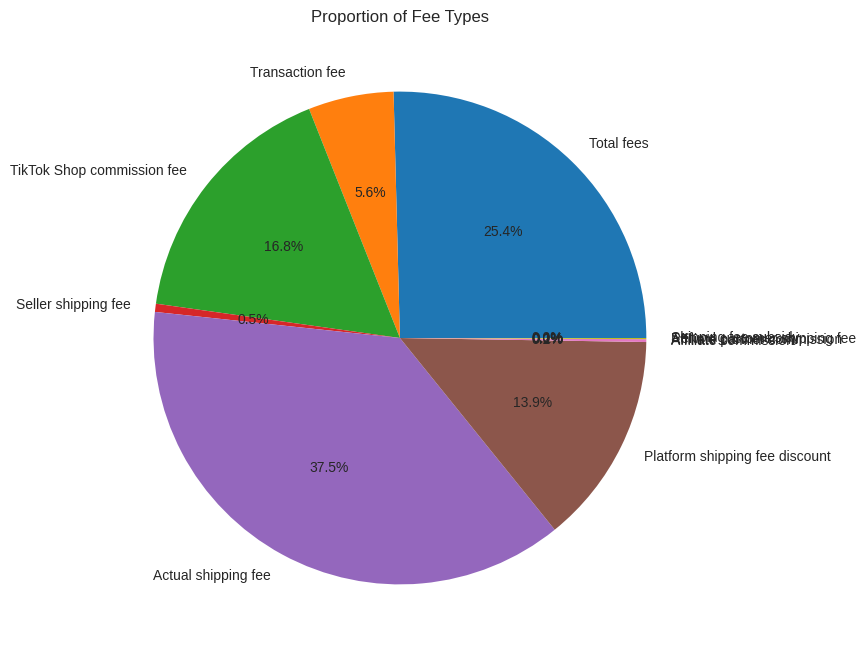

In [ ]:
fee_breakdown = df_income[fee_cols].abs().sum()

plt.figure(figsize=(8,8))
plt.pie(fee_breakdown, labels=fee_breakdown.index, autopct='%1.1f%%')
plt.title("Proportion of Fee Types")
plt.show()

* Shipping-related costs (actual shipping fee + platform shipping fee discount + seller shipping fee) account for over 52% of all fees.

* TikTok's commission fee is the second biggest cost driver.

**The largest proportion of fees comes from logistics**. Optimizing shipping—through batching, cheaper couriers, or consolidated shipping—could significantly improve profitability.

**TOP REVENUE DAYS**

In [ ]:
top_days = daily.sort_values("Net Revenue", ascending=False).head(10)
print("Top 10 Revenue Days:")
display(top_days)

Top 10 Revenue Days:


,Date,Total settlement amount,Total revenue,Net Revenue,Total Fees ABS,Has Refund
62,2025-09-14,11507.70,12778,11507.70,-3210.30,0
39,2025-08-17,8631.32,9776,8631.32,-3341.36,0
60,2025-09-10,8423.82,9346,8423.82,-2530.36,0
68,2025-09-21,7429.08,8754,7429.08,-2568.40,0
65,2025-09-18,5751.45,6766,5751.45,-2001.00,0
48,2025-08-27,4022.82,4466,4022.82,-1124.80,0
2,2025-06-29,3625.98,4020,3625.98,-1258.04,0
28,2025-07-31,3305.16,3690,3305.16,-1114.28,0
46,2025-08-25,3237.16,3664,3237.16,-1215.68,0
52,2025-08-31,2937.48,3248,2937.48,-809.04,0


**Top 3 Days**

* Sept 14 — ₱11,507 net revenue

* Aug 17 — ₱8,631

* Sept 10 — ₱8,423

There is high settlement amounts correlate with extremely high sales volume. Fees are also high on these days (₱2,000–₱3,000+). All top revenue days have zero refunds.

Revenue peaks cluster around mid-August to late September, suggesting a **seasonal or campaign-driven pattern**. **Targeting future promotions during these periods may maximize earnings**.

**SUMMARY STATISTICS**

In [ ]:
summary_stats = daily.describe()
print("\nDaily Summary Statistics:")
display(summary_stats)


Daily Summary Statistics:


,Total settlement amount,Total revenue,Net Revenue,Total Fees ABS,Has Refund
count,77.000000,77.000000,77.000000,77.000000,77.0
mean,1268.468442,1434.285714,1268.468442,-450.600130,0.0
std,2202.759431,2481.249372,2202.759431,718.170893,0.0
min,-27.000000,0.000000,-27.000000,-3341.360000,0.0
25%,-5.400000,0.000000,-5.400000,-635.740000,0.0
50%,158.840000,198.000000,158.840000,-94.560000,0.0
75%,1600.260000,1877.000000,1600.260000,0.000000,0.0
max,11507.700000,12778.000000,11507.700000,0.000000,0.0


Income is highly skewed. The business relies heavily on a few strong performance days while most days produce minimal revenue.

There is a large gaps between peak and normal days, indicating unstable income. Median revenue (₱198) is very small compared to the maximum, confirming that most days gGenerate very little income and are outweighed by a few highly profitable days.

##**4. Core Stats**

In [ ]:
files = [
    "/content/Core Stats_20251005065621.xlsx - Sheet2.csv",
    "/content/Core Stats_20251005065558.xlsx - Sheet2.csv",
    "/content/Core Stats_20251005065605.xlsx - Sheet2.csv",
    "/content/Core Stats_20251005065613.xlsx - Sheet2.csv"
]

core_dfs = []

In [ ]:
def load_core_stats(path):
    print(f"\nLoading: {path}")

    # Load CSV
    df = pd.read_csv(path, header=0)

    # Clean column names
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.replace("\ufeff", "", regex=False)
        .str.replace("\n", " ", regex=False)
    )

    # Add a source file identifier
    df["Source_File"] = path.split("/")[-1]

    return df

In [ ]:
for f in files:
    try:
        df_temp = load_core_stats(f)
        core_dfs.append(df_temp)
    except Exception as e:
        print(f"⚠️ Error loading {f}: {e}")


Loading: /content/Core Stats_20251005065621.xlsx - Sheet2.csv

Loading: /content/Core Stats_20251005065558.xlsx - Sheet2.csv

Loading: /content/Core Stats_20251005065605.xlsx - Sheet2.csv

Loading: /content/Core Stats_20251005065613.xlsx - Sheet2.csv


In [ ]:
df_core = pd.concat(core_dfs, ignore_index=True)
print("\nCombined shape BEFORE dropping duplicates:", df_core.shape)


Combined shape BEFORE dropping duplicates: (96, 14)


In [ ]:
date_col_candidates = [col for col in df_core.columns if "time" in col.lower() or "date" in col.lower()]

if len(date_col_candidates) > 0:
    date_col = date_col_candidates[0]
    print("Detected date column:", date_col)
    df_core[date_col] = pd.to_datetime(df_core[date_col], errors="coerce")
else:
    print("⚠️ No date-like column found!")

Detected date column: Time


In [ ]:
df_core = df_core.drop_duplicates()
print("Combined shape AFTER dropping duplicates:", df_core.shape)

Combined shape AFTER dropping duplicates: (96, 14)


In [ ]:
if len(date_col_candidates) > 0:
    df_core = df_core.sort_values(date_col).reset_index(drop=True)
    print("Sorted by:", date_col)
else:
    print("Skipping sorting — no date column found.")

Sorted by: Time


In [ ]:
output_path = "/content/CoreStats_FULL_CLEANED.csv"
df_core.to_csv(output_path, index=False)

In [ ]:
df_core = pd.read_csv("/content/CoreStats_FULL_CLEANED.csv")
df_core.head()

,Time,Shop Tab GMV (₱),Avg. GMV per customer (₱),Refunded amount (₱),Product Viewers,Unique product clicks,Add to cart Visitor,Orders,Customers,Refunded orders,Impression to click conversion rate,Click to paid conversion rate,Impression to paid conversion rate,Source_File
0,2025-07-01,1128.00,1128.00,0.0,28,4,1,2,1,0,14.29%,25.00%,3.57%,Core Stats_20251005065613.xlsx - Sheet2.csv
1,2025-07-02,183.33,91.66,0.0,41,6,2,2,2,0,14.63%,33.33%,4.88%,Core Stats_20251005065613.xlsx - Sheet2.csv
2,2025-07-03,0.00,0.00,0.0,33,2,1,0,0,0,6.06%,0.00%,0.00%,Core Stats_20251005065613.xlsx - Sheet2.csv
3,2025-07-04,0.00,0.00,0.0,29,3,0,0,0,0,10.34%,0.00%,0.00%,Core Stats_20251005065613.xlsx - Sheet2.csv
4,2025-07-05,0.00,0.00,0.0,30,2,1,0,0,0,6.67%,0.00%,0.00%,Core Stats_20251005065613.xlsx - Sheet2.csv


###**Core Stats Analysis & Visualizations**

In [ ]:
# Clean column names
df_core.columns = df_core.columns.astype(str).str.strip().str.replace("\ufeff","", regex=False)

# Convert Time column
df_core["Time"] = pd.to_datetime(df_core["Time"], errors="coerce")
df_core = df_core.sort_values("Time").reset_index(drop=True)

In [ ]:
percent_cols = [
    "Impression to click conversion rate",
    "Click to paid conversion rate",
    "Impression to paid conversion rate"
]

def convert_percent(x):
    if pd.isna(x): return 0
    x = str(x).replace("%","").strip()
    try: return float(x)/100
    except: return 0

for col in percent_cols:
    df_core[col] = df_core[col].apply(convert_percent)


###**GMV Trend**

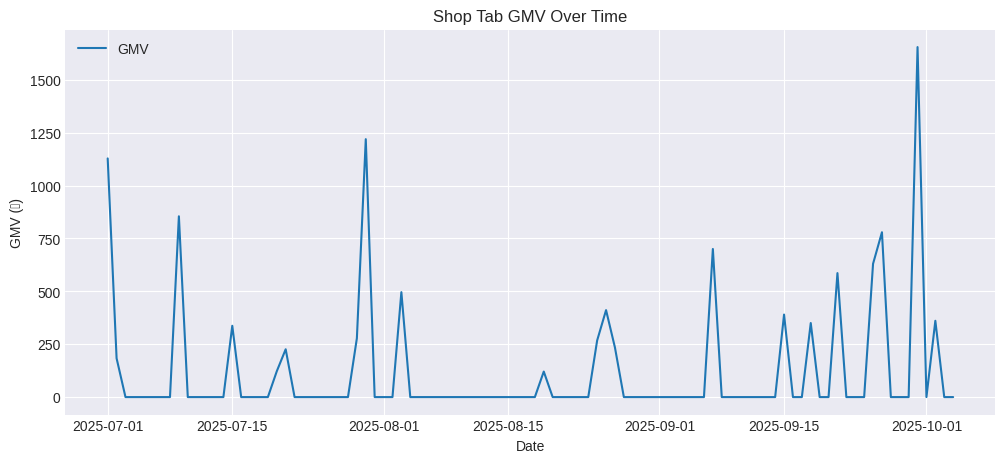

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_core["Time"], df_core["Shop Tab GMV (₱)"], label="GMV")
plt.title("Shop Tab GMV Over Time")
plt.xlabel("Date")
plt.ylabel("GMV (₱)")
plt.legend()
plt.show()

GMV shows high volatility, with numerous days recording ₱0 GMV, meaning no purchases were made.

Occasional spikes appear around:

* Early July (~₱1,100)

* Late July (~₱1,200)

* Mid-September (~₱700)

* Late September (~₱1,800; highest)

GMV does not trend upward or downward — it is episodic, not consistent.

---
The store’s GMV performance is irregular and depends heavily on a few peak days likely caused by promos, algorithm boosts, or viral content. Most days generate no revenue, indicating inconsistent conversion despite stable traffic.

---

###**Product Viewers, Clicks, Add to Cart**

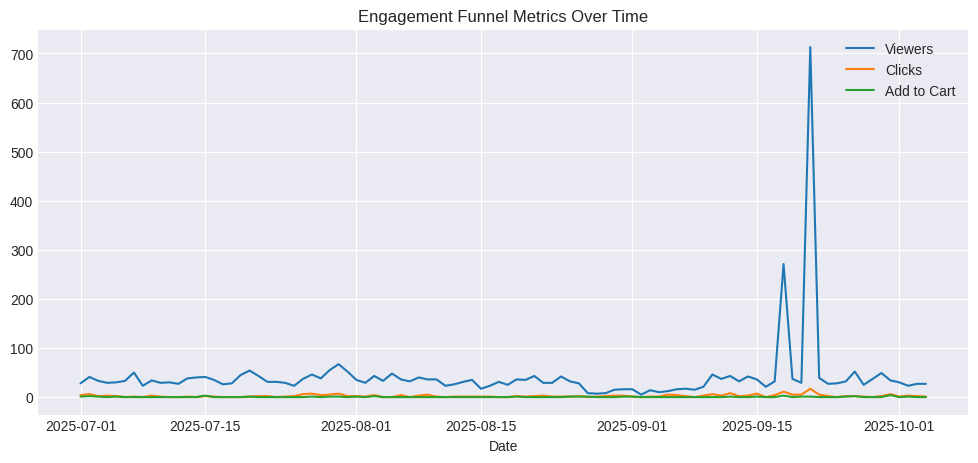

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_core["Time"], df_core["Product Viewers"], label="Viewers")
plt.plot(df_core["Time"], df_core["Unique product clicks"], label="Clicks")
plt.plot(df_core["Time"], df_core["Add to cart Visitor"], label="Add to Cart")
plt.title("Engagement Funnel Metrics Over Time")
plt.xlabel("Date")
plt.legend()
plt.show()

**Observations**
* Viewers range from 20–60 on most days, indicating consistent product exposure.
* licks stay extremely low (0–5 per day), showing a big drop-off after impressions.
* Add to Cart is almost always between 0–1 daily.
* A rare spike in viewers occurs (over 700), but clicks did NOT increase proportionally.

The product receives **stable visibility but fails to convert attention into meaningful engagement**. The large gap between viewers and clicks suggests weak product appeal, ineffective thumbnails/titles, or mismatch between audience intent and product offering.

**Business implication**
* Improving thumbnail, product title, and first 3 seconds of video content may raise Click-Through Rate.

* The huge spike in viewers without conversion suggests wasted exposure.

---

###**Orders & Customers**

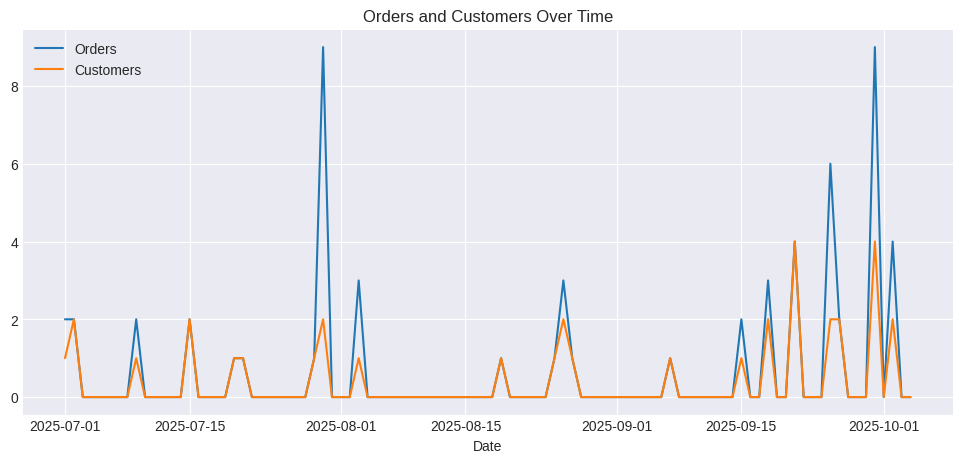

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_core["Time"], df_core["Orders"], label="Orders")
plt.plot(df_core["Time"], df_core["Customers"], label="Customers")
plt.title("Orders and Customers Over Time")
plt.xlabel("Date")
plt.legend()
plt.show()

Most days show 0–1 orders, with rare days showing 2–4 orders. Two noticeable spikes in Early August (9 orders) and Late September (9 orders). Customers follow the same pattern since 1 customer ≈ 1 order.

Purchase activity is extremely low and sporadic. Despite steady product views, only a small fraction convert to actual purchases. High-order days appear linked to specific events (e.g., content boosts or short campaigns).

###**Conversion Rate Trends**

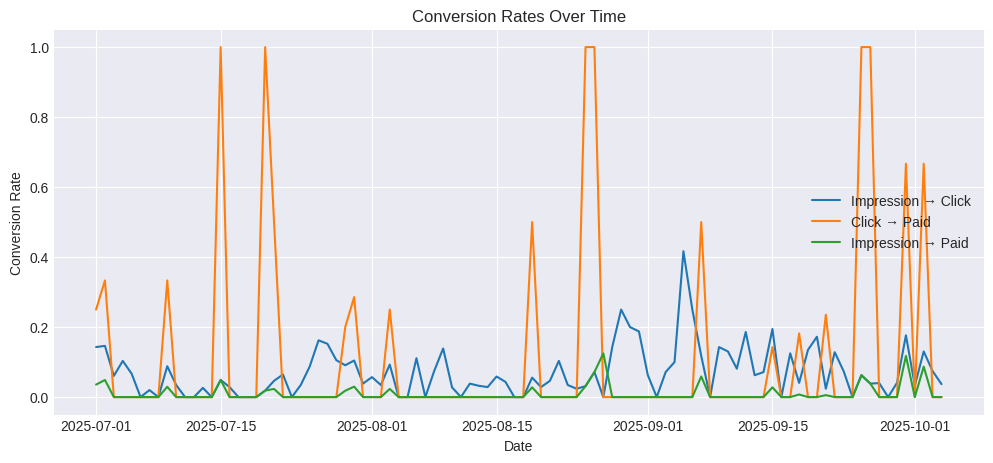

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_core["Time"], df_core["Impression to click conversion rate"], label="Impression → Click")
plt.plot(df_core["Time"], df_core["Click to paid conversion rate"], label="Click → Paid")
plt.plot(df_core["Time"], df_core["Impression to paid conversion rate"], label="Impression → Paid")
plt.title("Conversion Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.legend()
plt.show()

**Metrics**:

* Impression → Click: usually 3–10%, some days up to 40%

* Click → Paid: usually 0%, with rare spikes to 100%

* Impression → Paid: nearly always 0–5%

**Observation**

* Click → Paid spikes happen when:

* Very low clicks occur, but 1 customer buys

* Hence 1 click = 1 purchase → mathematically it becomes 100%

*  Impression → Paid remains extremely low (<5%) consistently.

Conversion rates show high instability. Most days yield no conversions, while small sample sizes cause occasional extreme spikes. Overall, the funnel efficiency is weak, indicating difficulty converting traffic into actual purchases.

###**CORRELATION HEATMAP**

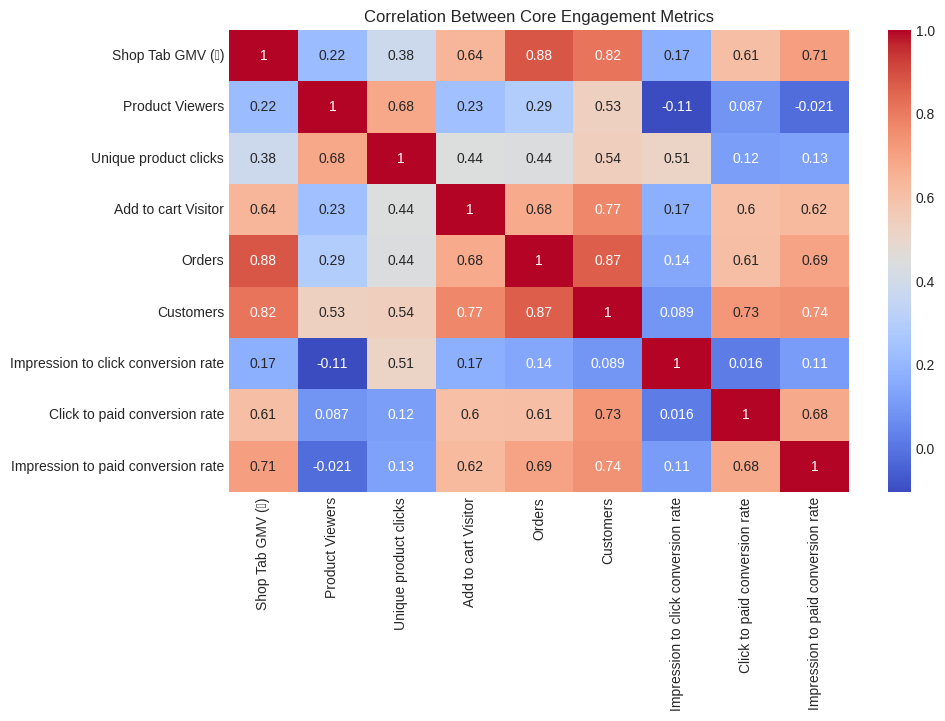

In [ ]:
plt.figure(figsize=(10,6))

heatmap_cols = [
    "Shop Tab GMV (₱)", "Product Viewers", "Unique product clicks",
    "Add to cart Visitor", "Orders", "Customers",
    "Impression to click conversion rate", "Click to paid conversion rate",
    "Impression to paid conversion rate"
]

sns.heatmap(df_core[heatmap_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Core Engagement Metrics")
plt.show()

**Strongest Positive Correlations**

* Orders ↔ GMV (0.88)

* Customers ↔ GMV (0.82)

* Add to Cart ↔ Orders (0.68)

* Add to Cart ↔ Customers (0.77)

* Impression → Paid ↔ GMV (0.71)

As expected, GMV is strongly driven by orders and customers. Add-to-cart behavior is a significant predictor of purchases. However, product viewers show weak correlation with conversions, indicating that high visibility does not guarantee sales. The real bottleneck is the mid-funnel stage (clicks → add-to-cart).